# Analyzing Mental Health among Students by Classifying Depression

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set(style="whitegrid")

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


## Load the dataset

In [ ]:
# Load dataset (if not already loaded)
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Student Depression Dataset.csv')
df.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


## Exploratory Data Analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

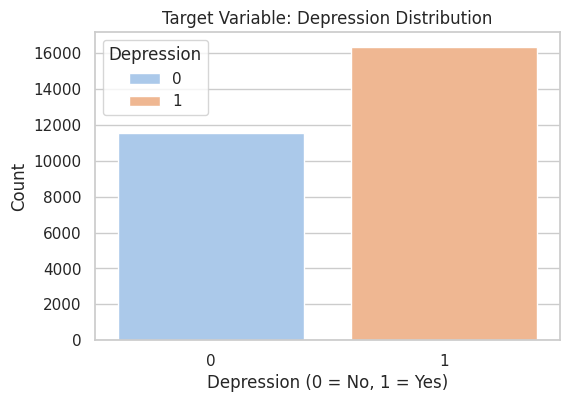

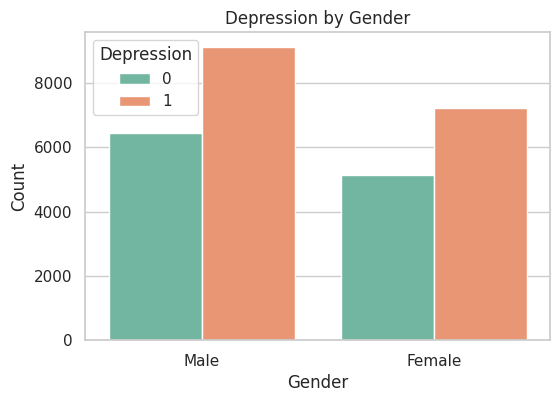

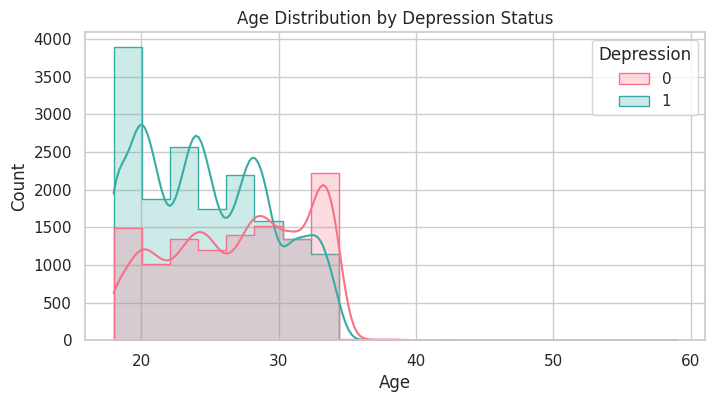

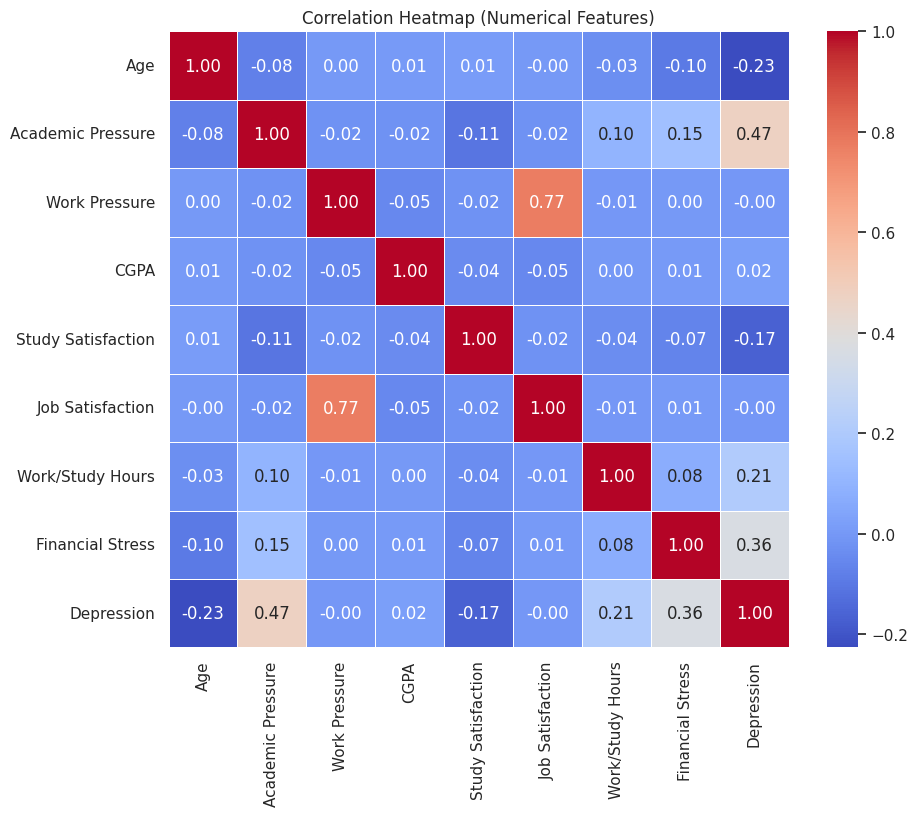

In [ ]:
# --- Dataframe info ---

print(df.info())

# --- Check for missing values ---
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values[missing_values > 0])

# --- Plot Target Variable: Depression ---
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Depression', hue='Depression', palette='pastel')
plt.title('Target Variable: Depression Distribution')
plt.xlabel('Depression (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

# --- Gender vs Depression ---
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Gender', hue='Depression', palette='Set2')
plt.title('Depression by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Depression')
plt.show()

# --- Age Distribution with Depression Overlay ---
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='Age', bins=20, kde=True, hue='Depression', element='step', palette='husl')
plt.title('Age Distribution by Depression Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# --- Correlation Heatmap for Numerical Features ---
# Select numeric columns excluding 'id'
numerical_cols = df.select_dtypes(include=['float64', 'int64']).drop(columns=['id']).columns

# Compute correlation matrix
corr_matrix = df[numerical_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap (Numerical Features)')
plt.show()

## Data Cleaning & Preprocessing

In [ ]:
df_clean = df.copy()

# --- Drop ID column ---
df_clean.drop(columns=['id'], inplace=True)

# --- Handle missing values (fill Financial Stress with median) ---
df_clean['Financial Stress'] = df_clean['Financial Stress'].fillna(df_clean['Financial Stress'].median())

# --- Convert 'Sleep Duration' from strings like '7 hours' to numeric ---
df_clean['Sleep Duration'] = df_clean['Sleep Duration'].str.extract(r'(\d+\.?\d*)').astype(float)

# --- Encode categorical columns ---

# Identify categorical columns
categorical_cols = df_clean.select_dtypes(include='object').columns.tolist()
print("categorical columns: ", categorical_cols)

# Excluding categorical columns that can be binary encoded
categorical_cols.remove('Have you ever had suicidal thoughts ?')
categorical_cols.remove('Family History of Mental Illness')

# One-hot encode general categoricals (drop_first=True to avoid dummy variable trap)
df_clean = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

# Encode binary categorical columns
binary_map = {'Yes': 1, 'No': 0}
df_clean['Have you ever had suicidal thoughts ?'] = df_clean['Have you ever had suicidal thoughts ?'].map(binary_map)
df_clean['Family History of Mental Illness'] = df_clean['Family History of Mental Illness'].map(binary_map)

# --- Standardize numerical features ---

# Exclude target column from scaling
features = df_clean.drop('Depression', axis=1)
target = df_clean['Depression']

# Apply standardization
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Rebuild final preprocessed DataFrame
X = pd.DataFrame(features_scaled, columns=features.columns)
y = target

# Drop NaNs from X and y
X = X.dropna()
y = y[X.index]  # Keep y in sync

print("input data: ")
print(X)
print("target data: ")
print(y)

categorical columns:  ['Gender', 'City', 'Profession', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
input data: 
            Age  Academic Pressure  Work Pressure      CGPA  \
0      1.463165           1.345543      -0.009777  0.893393   
1     -0.371474          -0.826104      -0.009777 -1.194076   
2      1.055467          -0.102222      -0.009777 -0.425724   
3      0.443921          -0.102222      -0.009777 -1.404862   
4     -0.167625           0.621660      -0.009777  0.322229   
...         ...                ...            ...       ...   
27896  0.240073           1.345543      -0.009777 -1.296069   
27897  0.240073          -0.826104      -0.009777  1.185774   
27898  1.055467          -0.102222      -0.009777 -0.711306   
27899 -1.594566           1.345543      -0.009777 -0.527718   
27900  0.240073           0.621660      -0.009777  1.076981   

       Study Satisfaction  Job Satisfaction  Sleep Duration  \
0      

## RNN Model for Classification

Class Weights: {0: np.float64(1.2063818280151433), 1: np.float64(0.853916239185361)}
Epoch 1/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6361 - loss: 0.6711 - val_accuracy: 0.8339 - val_loss: 0.4793
Epoch 2/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8318 - loss: 0.4246 - val_accuracy: 0.8436 - val_loss: 0.3669
Epoch 3/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8398 - loss: 0.3702 - val_accuracy: 0.8431 - val_loss: 0.3625
Epoch 4/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8382 - loss: 0.3709 - val_accuracy: 0.8427 - val_loss: 0.3630
Epoch 5/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8400 - loss: 0.3702 - val_accuracy: 0.8451 - val_loss: 0.3623
Epoch 6/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8506 - loss: 0.3595 - val_accuracy: 0.8458 - val_loss: 0.3612
Epoch 7/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8446 - loss: 0.3656 - val_accuracy: 0.8449 - val_loss: 0.3615
Epoch 8/30
558/558 

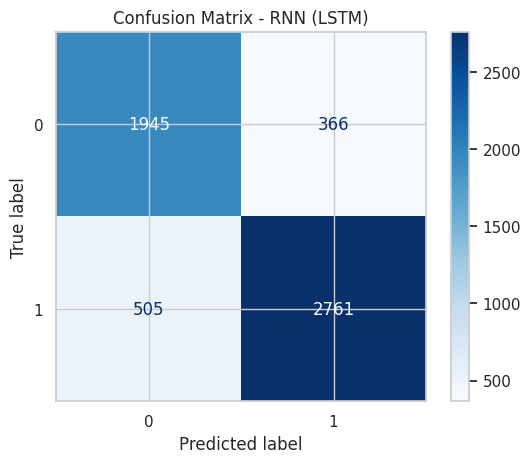

In [ ]:
# --- Reshape data ---
X_reshaped = X.values.reshape((X.shape[0], 1, X.shape[1]))  # (samples, 1 timestep, features)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42, stratify=y
)

# --- Class weights to handle imbalance ---
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: class_weights_array[i] for i in range(len(class_weights_array))}
print("Class Weights:", class_weights_dict)

# --- Build LSTM model ---
model_rnn = Sequential([
    tf.keras.Input(shape=(1, X.shape[1])),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# --- Compile with gradient clipping and low LR ---
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
model_rnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# --- Train model ---
history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict
)

# --- Predict and evaluate ---
y_pred_probs = model_rnn.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# --- Confusion matrix plot ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - RNN (LSTM)")
plt.show()

## Transformer Model for Classification

Epoch 1/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.5709 - loss: 0.7428 - val_accuracy: 0.8234 - val_loss: 0.3983
Epoch 2/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7992 - loss: 0.4435 - val_accuracy: 0.8389 - val_loss: 0.3714
Epoch 3/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8250 - loss: 0.4005 - val_accuracy: 0.8413 - val_loss: 0.3707
Epoch 4/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8364 - loss: 0.3915 - val_accuracy: 0.8393 - val_loss: 0.3711
Epoch 5/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8436 - loss: 0.3784 - val_accuracy: 0.8409 - val_loss: 0.3631
Epoch 6/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8418 - loss: 0.3783 - val_accuracy: 0.8404 - val_loss: 0.3743
Epoch 7/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8427 - loss: 0.3768 - val_accuracy: 0.8418 - val_loss: 0.3703
Epoch 8/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8401 - loss: 0.3772 - val_accuracy

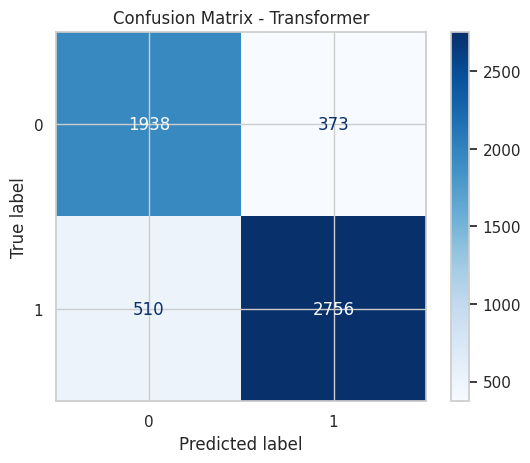

In [ ]:
# --- Reshape tabular data as sequence ---
X_reshaped = X.values.reshape((X.shape[0], 1, X.shape[1]))  # (samples, 1-dim embedding, features as tokens,)

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42, stratify=y
)

# --- Compute Class Weights ---
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: class_weights_array[i] for i in range(len(class_weights_array))}

# --- Build Transformer Encoder Block ---
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.2):
    # Multi-head attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feedforward
    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = Add()([x, x_ff])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

# --- Build Full Transformer Model ---
input_layer = Input(shape=(1, X.shape[1]))

x = transformer_block(input_layer, head_size=16, num_heads=2, ff_dim=32)
x = transformer_block(x, head_size=16, num_heads=2, ff_dim=32)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model_transformer = Model(inputs=input_layer, outputs=output)

# --- Compile ---
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
model_transformer.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# --- Train ---
history_transformer = model_transformer.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict
)

# --- Predict and Evaluate ---
y_pred_probs = model_transformer.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Transformer")
plt.show()